In [1]:
import os
import pandas as pd
import numpy as np

import sys
sys.path.append("./scripts/")

from process import bidExcelProcessing, bidExcelFormat, migration, plotBidPercentages
from extract import filterDownloadExcel, relatedSheetProcessing
from reformat import splitFileCal

cpath = "/Users/junyelu/Desktop/cost.xlsx"
ppath = "/Users/junyelu/Desktop/Parameters.xlsx"

In [2]:
fpath = '/Users/junyelu/Desktop/架空绝缘导线（二）-宁夏.xlsx'
outpath = '/Users/junyelu/Desktop/宁夏1kV架空.xlsx'

data = splitFileCal(fpath, outpath)


./scripts/reformat.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.loc[:, '投标价格'] = dataframe['投标价格'].astype(str)
./scripts/reformat.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['投标价格'] = dataframe['投标价格'].str.replace(',', '')
./scripts/reformat.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

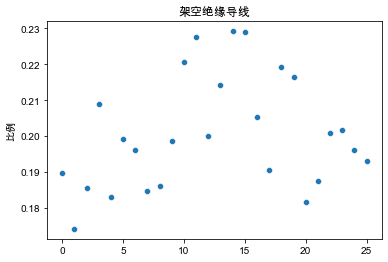

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
filePath = "/Users/junyelu/Desktop/甘肃.xlsx"
plotBidPercentages(filePath)

In [ ]:
opath = '/Users/junyelu/Desktop/货物清单_国网上海市电力公司2022年新增用户接入工程物资协议库存招标采购20221122_121646_179.xlsx'
filterDownloadExcel(opath)

In [ ]:
rpath = '/Users/junyelu/Desktop/相关清单/黑龙江省相关清单.xlsx'
relatedSheetProcessing(rpath, ppath)

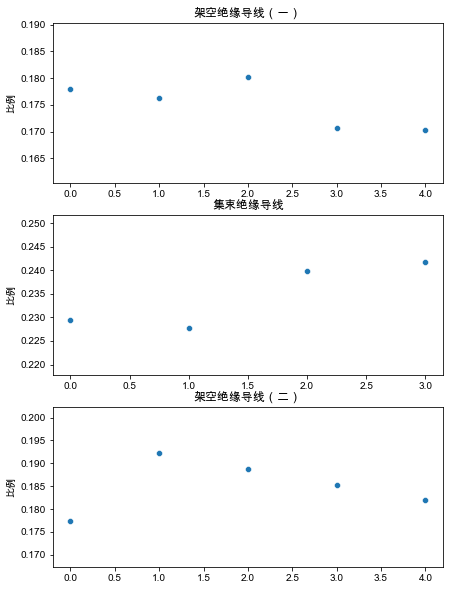

In [2]:
loc = "宁夏"
fpath = "/Users/junyelu/Desktop/相关清单/"+loc+"相关清单.xlsx"
outpath = "/Users/junyelu/Desktop/"+loc+".xlsx"

# bidExcelProcessing(fpath, cpath, ppath, outpath)
# bidExcelFormat(outpath)
plotBidPercentages(outpath)

In [ ]:
#Path migration
ipath = '/Users/junyelu/Desktop/山西.xlsx'
outpath = "/Users/junyelu/Desktop/山西10kV架空绝缘导线.xlsx"
migration(ipath, outpath)

In [ ]:
#Parameters reassessing
import os

import pandas as pd
sourceFolder = '/Users/junyelu/Desktop/Files Compost/2021 Work/Bidding/SGCC1'
pd.set_option('display.max_rows', 999)

fileAddress = []
for root, dirs, files in os.walk(sourceFolder):
    if '江苏' in root and '开标' in root:
        for file in files:
            if '金具' not in file:
                fileAddress.append(root+'/'+file)

tmp = pd.read_excel(fileAddress[1], sheet_name=None)
for key, sheet in tmp.items():
    print(sheet.iloc[5, -2] + sheet.iloc[3, -2])


In [ ]:
import os
import pandas as pd
sourceFolder = '/Users/junyelu/Desktop/Files Compost/Work/2022 Bidding/SGCC1'
pd.set_option('display.max_rows', 999)

folders_path = []
for file in os.listdir(sourceFolder):
    if '开标' in file:
        folders_path.append(sourceFolder+"/"+file)

concat_files = []
required_columns = ['分标编号','分标名称','项目单位','分包名称','投标人名称','投标价格']
for folder_path in folders_path:
    for file in os.listdir(folder_path):
        if file.endswith('.xlsx') and '金具' not in file:
            print(f'Processing {folder_path, file}')
            concat_files.append(pd.concat(pd.read_excel(folder_path+"/"+file, sheet_name=None, usecols=required_columns), ignore_index=True))
concat_files

In [ ]:
prov_202102_pd = pd.DataFrame.from_dict(prov_202102, orient="index", columns=['Occurence2102'])

In [ ]:
prov_202101_pd = pd.DataFrame.from_dict(prov_202101, orient="index", columns=['Occurence2101'])

In [ ]:
prov_202201_pd = pd.DataFrame.from_dict(prov_202201, orient="index", columns=['Occurence2201'])

In [ ]:
temp = prov_202101_pd.join(prov_202102_pd, how="outer")

In [ ]:
pd.concat(concat_files, ignore_index=True).to_excel('统计.xlsx')

In [ ]:
import pandas
pandas.__version__

In [ ]:
import openpyxl
openpyxl.__version__